# Decompositions and least squares


In this lecture, we look at several factorizations of a matrix. For a square or rectangular matrix $A ∈ ℝ^{m × n}$ with more rows than columns ($m ≥ n$), we consider:
1. The _QR decomposition_
$$
A = Q R = \underbrace{\begin{bmatrix} 𝐪_1 | \cdots | 𝐪_m \end{bmatrix}}_{m × m} \underbrace{\begin{bmatrix} × & \cdots & × \\ & \ddots & \vdots \\ && × \\ &&0 \\ &&\vdots \\ && 0 \end{bmatrix}}_{m × n}
$$
where $Q$ is orthogonal ($Q^⊤Q = I$, $𝐪_j ∈ ℝ^m$) and $R$ is _right triangular_, which means it 
is only nonzero on or to the right of the diagonal.

2. The _reduced QR decomposition_
$$
A = Q̂ R̂ = \underbrace{\begin{bmatrix} 𝐪_1 | \cdots | 𝐪_n \end{bmatrix}}_{m × n} \underbrace{\begin{bmatrix} × & \cdots & × \\ & \ddots & \vdots \\ && ×  \end{bmatrix}}_{n × n}
$$
where $Q$ has orthogonal columns ($Q^⊤Q = I$, $𝐪_j ∈ ℝ^m$) and $R̂$ is upper triangular.

For a square matrix we consider the _PLU decomposition_:
$$
A = P^⊤ LU
$$
where $P$ is a permutation matrix, $L$ is lower triangular and $U$ is upper triangular.

Finally, for a square, _symmetric positive definite_ ($𝐱^⊤ A 𝐱 > 0$ for all $𝐱 ∈ ℝ^n$) 
matrix we consider the _Cholesky decomposition_:
$$
A = L L^⊤
$$

The importance of these decomposition for square matrices is that their component pieces are easy to invert on a computer:
$$
\begin{align*}
A = P^⊤ LU &\Rightarrow\qquad A^{-1}𝐛 = U^{-1} L^{-1} P 𝐛 \\
A = QR &\Rightarrow\qquad A^{-1}𝐛 = R^{-1} Q^\top 𝐛 \\
A = L L^⊤ &\Rightarrow\qquad A^{-1}𝐛 = L^{-⊤} L^{-1} 𝐛
\end{align*}
$$
and we saw last lecture that triangular and orthogonal matrices are easy to invert when applied to a vector $𝐛$,
e.g., using forward/back-substitution.
For rectangular matrices we will see that they lead to efficient solutions to the _least squares problem_: find
$𝐱$ that minimizes the 2-norm
$$
\| A 𝐱 - 𝐛 \|.
$$

In this lecture we discuss the followng:

1. QR and least squares: We discuss the QR decomposition and its usage in solving least squares problems.
2. Reduced QR and Gram–Schmidt: We discuss computation of the Reduced QR decomposition using Gram–Schmidt
3. Householder reflections and QR: We discuss comuting the  QR decomposition using Householder reflections.
2. PLU decomposition: we discuss how the LU decomposition can be computed using Gaussian elimination, and the computation of
the PLU decomposition via Gaussian elimination with pivoting.
3. Cholesky decomposition: we introduce symmetric positive definite matrices and show that their LU decomposition can be re-interpreted
as a Cholesky decomposition.
4. Timings: we see the relative trade-off in speed between the different decompositions.

In [1]:
using LinearAlgebra, Plots, BenchmarkTools

## 1. QR and least squares

Here we consider rectangular matrices with more rows than columns.
A QR decomposition decomposes a matrix into an orthogonal matrix $Q$ times a right triangular matrix $R$. 
Note the QR decomposition contains within it the reduced QR decomposition:
$$
A = QR = \begin{bmatrix} Q̂ | 𝐪_{n+1} | ⋯ | 𝐪_m \end{bmatrix} \begin{bmatrix} R̂ \\  𝟎_{m-n × n} \end{bmatrix} = Q̂ R̂.
$$

### Relationship with least squares

We can use it to solve a least squares problem using the norm-preserving property (see PS3) of orthogonal matrices:
$$
\| A 𝐱 - 𝐛 \| = \| Q R 𝐱 - 𝐛 \| = \| R 𝐱 - Q^⊤ 𝐛 \| = \left \| 
\begin{bmatrix} R̂ \\ 𝟎_{m-n × n} \end{bmatrix} 𝐱 - \begin{bmatrix} Q̂^⊤ \\ 𝐪_{n+1}^⊤ \\ \vdots \\ 𝐪_m^⊤ \end{bmatrix}     𝐛 \right \|
$$
Now note that the rows $k > n$ are independent of $𝐱$ and are a fixed contribution. Thus to minimise this norm it suffices to
drop them and minimise:
$$
\| R̂ 𝐱 - Q̂^⊤ 𝐛 \|
$$
This norm is minimisable if it is attained. Provided the column rank of $A$ is full, $R̂$ will be invertible (Exercise: why is this?).
Thus we have the solution
$$
𝐱 = R̂^{-1} Q̂^⊤ 𝐛
$$

**Example (quadratic fit)** Suppose we want to find noisy data by a quadratic
$$
p(x) = a + bx + cx^2
$$
That is, we want to choose $a,b,c$ at data samples $x_1, \ldots, x_m$ so that the following is true:
$$
a + b x_k + c x_k^2 ≈ f_k
$$
where $f_k$ are given by data. We can reinterpret this as a least squares problem: minimise the norm
$$
\left\| \begin{bmatrix} 1 & x_1 & x_1^2 \\ \vdots & \vdots & \vdots \\ 1 & x_m & x_m^2 \end{bmatrix}
\begin{bmatrix} a \\ b \\ c \end{bmatrix} - \begin{bmatrix} f_1 \\ \vdots \\ f_m \end{bmatrix} \right \|
$$
We can solve this using the QR decomposition:

In [2]:
m,n = 100,3

x = range(0,1; length=m) # 100 points
f = 2 .+ x .+ 2x.^2 .+ 0.1 .* randn.() # Noisy quadratic

A = x .^ (0:2)'  # 100 x 3 matrix, equivalent to [ones(m) x x.^2]
Q,R̂ = qr(A)
Q̂ = Q[:,1:n] # Q represents full orthogonal matrix so we take first 3 columns

a,b,c = R̂ \ Q̂'f

3-element Vector{Float64}:
 1.9847336272993261
 1.182411169245391
 1.817960716608881

We can visualise the fit:

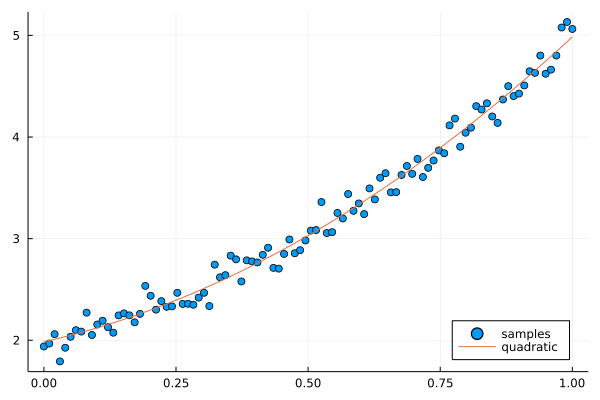

In [3]:
p = x -> a + b*x + c*x^2

scatter(x, f; label="samples", legend=:bottomright)
plot!(x, p.(x); label="quadratic")

Note that `\` with a rectangular system does least squares by default:

In [4]:
A \ f

3-element Vector{Float64}:
 1.984733627299327
 1.1824111692453907
 1.817960716608881

## 2. Reduced QR and Gram–Schmidt


How do we compute the QR decomposition? We begin with a method
you may have seen before in another guise. Write
$$
A = \begin{bmatrix} 𝐚_1 | \dots | 𝐚_n \end{bmatrix}
$$
where $𝐚_k \in  ℝ^m$.
Note that the column span of the first $j$ columns of $A$
will be the same as the first $j$ columns of $Q̂$, assuming that 
$R̂$ is non-singular:
$$
\hbox{span}(𝐚_1,\ldots,𝐚_j) = \hbox{span}(𝐪_1,\ldots,𝐪_j)
$$
In other words: the columns of $Q̂$ are an orthogonal basis
of the column span of $A$.
To see this note that since `R̂` is triangular we have
$$
\begin{bmatrix} 𝐚_1 | \dots | 𝐚_j \end{bmatrix} = \begin{bmatrix} 𝐪_1 | \dots | 𝐪_j \end{bmatrix}  R̂[1:j,1:j]
$$
for all $j$. That is, if $𝐯 ∈ \hbox{span}(𝐚_1,\ldots,𝐚_j)$ we have for $𝐜 ∈ ℝ^j$
$$
𝐯 = \begin{bmatrix} 𝐚_1 | \dots | 𝐚_j \end{bmatrix} 𝐜 = \begin{bmatrix} 𝐪_1 | \dots | 𝐪_j \end{bmatrix}  R̂[1:j,1:j] 𝐜 ∈ \hbox{span}(𝐪_1,\ldots,𝐪_j)
$$
 while if $𝐰 ∈ \hbox{span}(𝐪_1,\ldots,𝐪_j)$ we have for $𝐝 ∈ ℝ^j$
$$
𝐰 = \begin{bmatrix} 𝐪_1 | \dots | 𝐪_j \end{bmatrix} 𝐝  =  \begin{bmatrix} 𝐚_1 | \dots | 𝐚_j \end{bmatrix} R̂[1:j,1:j]^{-1} 𝐜 ∈  \hbox{span}(𝐚_1,\ldots,𝐚_j).
$$

 
It is possible to find an orthogonal basis using the _Gram–Schmidt algorithm_,
We construct it via induction:
assume that
$$
\hbox{span}(𝐚_1,\ldots,𝐚_{j-1}) = \hbox{span}(𝐪_1,\ldots,𝐪_{j-1})
$$
where $𝐪_1,\ldots,𝐪_{j-1}$ are orthogonal:
$$
𝐪_k^\top 𝐪_ℓ = δ_{kℓ} = \begin{cases} 1 & k  ℓ \\
                                            0 & \hbox{otherwise} \end{cases}.
$$
for $k,ℓ < 1$.
Define
$$
𝐯_j := 𝐚_j - \sum_{k=1}^{j-1} \underbrace{𝐪_k^\top 𝐚_j}_{r_{kj}} 𝐪_k
$$
so that for $k < j$
$$
𝐪_k^\top 𝐯_j = 𝐪_k^\top 𝐚_j - \sum_{k=1}^{j-1} \underbrace{𝐪_k^\top 𝐚_j}_{r_{kj}} 𝐪_k^\top 𝐪_k = 0.
$$
Then we define
$$
𝐪_j := {𝐯_j \over \|𝐯_j\|}.
$$
which sastisfies the same properties as the assumption.

We now reinterpret this construction as a reduced QR decomposition.
Define
$
r_{jj} := {\|𝐯_j\|}
$
Then rearrange the definition we have
$$
𝐚_j = \begin{bmatrix} 𝐪_1|\cdots|𝐪_j \end{bmatrix} \begin{bmatrix} r_{1j} \\ \vdots \\ r_{jj} \end{bmatrix}
$$
Thus
$$
\begin{bmatrix} 𝐚_1|\cdots|𝐚_j \end{bmatrix} 
\begin{bmatrix} r_{11} & \cdots & r_{1j} \\ & \ddots & \vdots \\ && r_{jj} \end{bmatrix}
$$
That is, we are computing the reduced QR decomposition column-by-column. Running this algorithm to $j = n$ completes the decomposition.

### Gram–Schmidt in action

We are going to compute the reduced QR of a random matrix

In [5]:
m,n = 5,4
A = randn(m,n)
Q,R̂ = qr(A)
Q̂ = Q[:,1:n]

5×4 Matrix{Float64}:
 -0.143133   -0.811478   0.539123    -0.0761824
  0.872834   -0.238129   0.00903372   0.24734
  0.290362   -0.212093  -0.44393     -0.752129
  0.365026    0.411971   0.528438    -0.00482459
  0.0109569   0.264755   0.482642    -0.606051

In [6]:
R̂

4×4 Matrix{Float64}:
 -1.64361  -0.666542   0.0735355   0.920278
  0.0      -4.30241   -0.293683    0.487173
  0.0       0.0        1.35936     0.111035
  0.0       0.0        0.0        -1.03174

The first column of `Q̂` is indeed a normalised first column of `A`:

In [7]:
R = zeros(n,n)
Q = zeros(m,n)
R[1,1] = norm(A[:,1])
Q[:,1] = A[:,1]/R[1,1]

5-element Vector{Float64}:
  0.14313314215292067
 -0.8728336386305662
 -0.2903621427193295
 -0.36502618555655897
 -0.010956862042875182

We now determine the next entries as

In [8]:
R[1,2] = Q[:,1]'A[:,2]
v = A[:,2] - Q[:,1]*R[1,2]
R[2,2] = norm(v)
Q[:,2] = v/R[2,2]

5-element Vector{Float64}:
  0.8114777365369767
  0.23812860032451597
  0.21209292062098267
 -0.41197089677767695
 -0.26475503025055075

And the third column is then:

In [9]:
R[1,3] = Q[:,1]'A[:,3]
R[2,3] = Q[:,2]'A[:,3]
v = A[:,3] - Q[:,1:2]*R[1:2,3]
R[3,3] = norm(v)
Q[:,3] = v/R[3,3]

5-element Vector{Float64}:
  0.539123130932316
  0.009033718851000613
 -0.4439302846131371
  0.5284381345484396
  0.482642395543245

(Note the signs may not necessarily match.)

We can clean this up as a simple algorithm:

In [10]:
function gramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        for k = 1:j-1
            R[k,j] = Q[:,k]'*A[:,j]
        end
        v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    Q,R
end

Q,R = gramschmidt(A)
norm(A - Q*R)

4.972820174300706e-16

### Complexity and stability

We see within the `for j = 1:n` loop that we have $O(mj)$ operations. Thus the 
total complexity is $O(m n^2)$ operations.


Unfortunately, the Gram–Schmidt algorithm is _unstable_: the rounding errors when implemented in floating point
accumulate in a way that we lose orthogonality:

In [11]:
A = randn(300,300)
Q,R = gramschmidt(A)
norm(Q'Q-I)

2.790456072279384e-12

## 3. Householder reflections and QR

As an alternative, we will consider using Householder reflections to introduce zeros below
the diagonal.
Thus, if Gram–Schmidt is a process of _triangular orthogonalisation_ (using triangular matrices
to orthogonalise), Householder reflections is a process of _orthogonal triangularisation_ 
(using orthogonal matrices to triangularise).

Consider multiplication by the Householder reflection corresponding to the first column,
that is, for
$$
Q_1 := Q_{𝐚_1}^{\rm H},
$$
consider
$$
Q_1 A = \begin{bmatrix} \times & \times & \cdots & \times \\
& \times & \cdots & \times \\
                    & \vdots & \ddots & \vdots \\
                    & \times & \cdots & \times \end{bmatrix} = 
\begin{bmatrix} r_{11} & r_{12} & \cdots & r_{1n} \\ 
& 𝐚_2^1 & \cdots & 𝐚_n^1   \end{bmatrix}
$$
where 
$$
r_{1j} :=  (Q_1 𝐚_j)[1] \qquad \hbox{and} \qquad 𝐚_j^1 := (Q_1 𝐚_j)[2:m],
$$
noting $r_{11} = -\hbox{sign}(a_{11})\|𝐚_1\|$ and all entries of $𝐚_1^1$ are zero (thus not included).
That is, we have made the first column triangular.

But now consider
$$
Q_2 := \begin{bmatrix} 1  \\ & Q_{𝐚_2^1}^{\rm H} \end{bmatrix} = Q_{\begin{bmatrix} 0 \\ 𝐚_2^1 \end{bmatrix}}^H
$$
so that
$$
Q_2 Q_1A = \begin{bmatrix} \times & \times & \times & \cdots & \times \\
& \times & \times  & \cdots & \times \\
                    && \vdots & \ddots & \vdots \\
                    && \times & \cdots & \times \end{bmatrix}  =  \begin{bmatrix} r_{11} & r_{12} & r_{13} & \cdots & r_{1n} \\ 
    & r_{22} & r_{23} & \cdots & r_{2n} \\
&& 𝐚_3^2 & \cdots & 𝐚_n^2   \end{bmatrix}
$$
where 
$$
r_{2j} :=  (Q_2 𝐚_j^1)[1] \qquad \hbox{and} \qquad 𝐚_j^2 := (Q_2 𝐚_j^1)[2:m-1]
$$
Thus the first two columns are triangular. 

The inductive construction is thus clear. If we define $𝐚_j^0 := 𝐚_j$ we
have the construction
$$
\begin{align*}
Q_j &:= \begin{bmatrix} I_{j-1 \times j-1}  \\ & Q_{𝐚_j^j}^{±,\rm H} \end{bmatrix} \\
𝐚_j^k &:= (Q_k 𝐚_j^{k-1})[2:m-k+1] \\
r_{kj} &:= (Q_k 𝐚_j^{k-1})[1]
\end{align*}
$$
Then
$$
Q_n \cdots Q_1 A = \underbrace{\begin{bmatrix} 
r_{11} & \cdots & r_{1n} \\ & \ddots & \vdots\\
                                        && r_{nn} \\&& 0 \\ && \vdots \\ && 0 \end{bmatrix}}_R
$$
i.e.
$$
A = \underbrace{Q_n \cdots Q_1}_Q R.
$$

The implementation is cleaner. We do a naive implementation here:

In [12]:
function householderreflection(x)
    y = copy(x)
    # we cannot use sign(x[1]) in case x[1] == 0
    y[1] += (x[1] ≥ 0 ? 1 : -1)*norm(x) 
    w = y/norm(y)
    I - 2*w*w'
end
function householderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Matrix(1.0I, m, m)
    for j = 1:n
        Qⱼ = householderreflection(R[j:end,j])
        R[j:end,:] = Qⱼ*R[j:end,:]
        Q[:,j:end] = Q[:,j:end]*Qⱼ
    end
    Q,R
end

m,n = 7,5
A = randn(m, n)
Q,R = householderqr(A)
Q*R ≈ A

true

Note because we are forming a full matrix representation of each Householder
reflection this is a slow algorithm, taking $O(n^4)$ operations. The problem sheet
will consider a better implementation that takes $O(n^3)$ operations.


**Example** We will now do an example by hand. Consider the $4 \times 3$ matrix
$$
A = \begin{bmatrix} 
1 & 2 & -1 \\ 
0 & 15 & 18 \\
-2 & -4 & -4 \\
-2 & -4 & -10
\end{bmatrix}
$$
For the first column we have
$$
Q_1 = I - {1 \over 12} \begin{bmatrix} 4 \\ 0 \\ -2 \\ -2 \end{bmatrix} \begin{bmatrix} 4 & 0 & -2 & -2 \end{bmatrix} =
{1 \over 3} \begin{bmatrix}
-1 & 0 & 2 & 2 \\
0 & 3 & 0 & 0 \\
2 & 0 & 2 & -1 \\
2 & 0 & -1 &2
\end{bmatrix}
$$
so that
$$
Q_1 A = \begin{bmatrix} -3 & -6 & -9 \\
 & 15 & 18 \\
  & 0 & 0 \\
& 0 & -6
\end{bmatrix}
$$
In this example the next column is already upper-triangular,
but because of our choice of reflection we will end up swapping the sign, that is
$$
Q_2 = \begin{bmatrix} 1 \\ & -1 \\ && 1 \\ &&& 1 \end{bmatrix}
$$
so that
$$
Q_2 Q_1 A = \begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  & 0 & 0 \\
& 0 & -6
\end{bmatrix}
$$
The final reflection is
$$
Q_3 = \begin{bmatrix} I_{2 \times 2} \\ &  I - \begin{bmatrix} 1 \\ -1 \end{bmatrix} \begin{bmatrix}1 & -1 \end{bmatrix} 
\end{bmatrix}= \begin{bmatrix}1 \\ & 1 \\ & & 0 & 1 \\ & & 1 & 0 \end{bmatrix}
$$
giving us
$$
Q_3 Q_2 Q_1 A = \underbrace{\begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  &  & -6 \\
&  & 0
\end{bmatrix}}_R
$$
That is,
$$
A = Q_1 Q_2 Q_3 R = \underbrace{{1 \over 3} \begin{bmatrix}
-1 & 0 & 2 & 2 \\
0 & 3 & 0 & 0 \\
2 & 0 & -1 & 2 \\
2 & 0 & 2 &-1
\end{bmatrix}}_Q \underbrace{\begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  &  & -6 \\
&  & 0
\end{bmatrix}}_R = \underbrace{{1 \over 3} \begin{bmatrix}
-1 & 0 & 2  \\
0 & 3 & 0  \\
2 & 0 & -1  \\
2 & 0 & 2 
\end{bmatrix}}_Q̂  \underbrace{\begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  &  & -6 
\end{bmatrix}}_R̂
$$



## 2. PLU Decomposition

Just as Gram–Schmidt can be reinterpreted as a reduced QR decomposition,
Gaussian elimination with pivoting can be interpreted as a PLU decomposition.


### LU Decomposition

Before discussing pivoting, consider standard Gaussian elimation where one row-reduces
to introduce zeros column-by-column. We will mimick the computation of the QR decomposition
to view this as a _triangular triangularisation_.


Consider the matrix
$$
L_𝐯 = \begin{bmatrix} 1 \\ -{v_2 \over v_1} & 1 \\ \vdots &&\ddots \\
                -{v_n \over v_1}  &&& 1
                \end{bmatrix} = I -\left[{𝐯 \over v_1}  - 𝐞_1 \right] 𝐞_1^\top
$$
so that
$$
L_𝐯 𝐯 = 𝐯 - (𝐯 - v_1 𝐞_1) = v_1 𝐞_1.
$$
For $L_1 := L_{𝐚_1}$ we have 
$$
L_1 A =  \begin{bmatrix} u_{11} & u_{12} & \cdots & u_{1n} \\ 
& 𝐚_2^1 & \cdots & 𝐚_n^1   \end{bmatrix}
$$
where $𝐚_j^1 := (L_1 𝐚_j)[2:m]$ and $u_{1j} = a_{1j}$. But now consider
$$
L_2 := \begin{bmatrix} 1  \\ & L_{𝐚_2^1} \end{bmatrix}.
$$
Then
$$
L_2 L_1 A = \begin{bmatrix} u_{11} & u_{12} & u_{13} & \cdots & u_{1n} \\ 
    & u_{22} & u_{23} & \cdots & u_{2n} \\
&& 𝐚_3^2 & \cdots & 𝐚_n^2   \end{bmatrix}
$$
where 
$$
r_{2j} :=  (𝐚_j^1)[1] \qquad \hbox{and} \qquad 𝐚_j^2 := (L_2 𝐚_j^1)[2:m-1]
$$
Thus the first two columns are triangular. 

The inductive construction is again clear. If we define $𝐚_j^0 := 𝐚_j$ we
have the construction
$$
\begin{align*}
L_j &:= \begin{bmatrix} I_{j-1 \times j-1}  \\ & L_{𝐚_j^j} \end{bmatrix} \\
𝐚_j^k &:= (L_k 𝐚_j^{k-1})[2:m-k+1]
 \\
u_{kj} &:= (L_k 𝐚_j^{k-1})[1]
\end{align*}
$$
Then
$$
L_{n-1} \cdots L_1 A = \underbrace{\begin{bmatrix} 
u_{11} & \cdots & u_{1n} \\ & \ddots & \vdots\\
                                        && u_{nn}\end{bmatrix}}_U
$$
i.e.
$$
A = \underbrace{L_{n-1}^{-1} \cdots L_1^{-1}}_L U.
$$

Now we establish properties of our special class of lower-triangular matrices. Consider $n × n$ lower triangular
matrices that are equal to the identity matrix apart from in the $j$th column:
$$
L_j = \begin{bmatrix}
        1 \\ & \ddots \\ && 1 \\
                    ℓ_{j+1,j} & 1 \\
                    \vdots && \dots \\
                    ℓ_{n,j} & & & 1 \end{bmatrix} = I + \begin{bmatrix} 𝟎_j \\ 𝐥_j \end{bmatrix} 𝐞_j^⊤
$$
where $𝐥_j ∈ ℝ^{n-j}$. These satisify the following special properties:
$$
L_j^{-1} = \begin{bmatrix}
        1 \\ & \ddots \\ && 1 \\
                    -ℓ_{j+1,j} & 1 \\
                    \vdots && \dots \\
                    -ℓ_{n,j} & & & 1 \end{bmatrix} = I - \begin{bmatrix} 𝟎_j \\ 𝐥_j \end{bmatrix} 𝐞_j^⊤
$$
and if $k > j$
$$
L_j^{-1} L_k^{-1} =  I - \begin{bmatrix} 𝟎_j \\ 𝐥_j \end{bmatrix} 𝐞_j^⊤ -  \begin{bmatrix} 𝟎_k \\ 𝐥_k \end{bmatrix} 𝐞_k^⊤
$$
Thus we have
$$
L = \begin{bmatrix}

\end{bmatrix}
$$




**Example**
We will do a numerical example (by-hand is equivalent to Gaussian elimination).
The first lower triangular matrix is:

In [13]:
n = 4
A = randn(n,n)
L₁ = I -[0; A[2:end,1]/A[1,1]] * [1 zeros(1,n-1)]

4×4 Matrix{Float64}:
 1.0      -0.0  -0.0  -0.0
 2.84758   1.0  -0.0  -0.0
 6.42927  -0.0   1.0  -0.0
 2.38044  -0.0  -0.0   1.0

Which indeed introduces zeros in the first column:

In [14]:
A₁ = L₁*A

4×4 Matrix{Float64}:
 0.259695  -0.753272  -0.33174  1.08309
 0.0       -3.1365    -1.01392  2.10153
 0.0       -4.58487   -2.04177  7.14398
 0.0       -2.29932   -1.56761  2.4462

Now we make the next lower triangular operator:

In [15]:
L₂ = I - [0; 0; A₁[3:end,2]/A₁[2,2]] * [0 1 zeros(1,n-2)]

4×4 Matrix{Float64}:
  1.0  -0.0       -0.0  -0.0
 -0.0   1.0       -0.0  -0.0
 -0.0  -1.46178    1.0  -0.0
 -0.0  -0.733085  -0.0   1.0

So that

In [16]:
A₂ = L₂*L₁*A

4×4 Matrix{Float64}:
  0.259695     -0.753272     -0.33174   1.08309
  0.0          -3.1365       -1.01392   2.10153
  0.0          -6.10623e-16  -0.559636  4.072
 -1.11022e-16   5.55112e-16  -0.824314  0.905595

The last one is:

In [17]:
L₃ = I - [0; 0; 0; A₂[4:end,3]/A₂[3,3]] * [0 0 1 zeros(1,n-3)]

4×4 Matrix{Float64}:
  1.0  -0.0  -0.0      -0.0
 -0.0   1.0  -0.0      -0.0
 -0.0  -0.0   1.0      -0.0
 -0.0  -0.0  -1.47295   1.0

Giving us

In [18]:
U = L₃*L₂*L₁*A

4×4 Matrix{Float64}:
 0.259695  -0.753272     -0.33174       1.08309
 0.0       -3.1365       -1.01392       2.10153
 0.0        0.0          -0.559636      4.072
 0.0        4.44089e-16  -4.44089e-16  -5.09225

and

In [19]:
L = inv(L₁)*inv(L₂)*inv(L₃)

4×4 Matrix{Float64}:
  1.0      0.0       0.0      0.0
 -2.84758  1.0       0.0      0.0
 -6.42927  1.46178   1.0      0.0
 -2.38044  0.733085  1.47295  1.0

Note how the entries of `L` are indeed identical to the negative
lower entries of `L₁`, `L₂` and `L₃`.

**Example**

Consider the matrix
$$
A = \begin{bmatrix} 1 & 1 & 1 \\
                    2 & 4 & 8 \\
                    1 & 4 & 9
                    \end{bmatrix}
$$
We have
$$
L_2 L_1 A = L_2 \begin{bmatrix}1 \\ 
                        -2 & 1 \\ -1 &  & 1 \end{bmatrix} \begin{bmatrix} 1 & 1 & 1 \\
                    2 & 4 & 8 \\
                    1 & 4 & 9
                    \end{bmatrix}
    = \begin{bmatrix}1 \\ & 1\\ & -{3 \over 2} & 1 
    \end{bmatrix} \begin{bmatrix} 1 & 1 & 1 \\
                         & 2 & 6 \\
                         & 3 & 8 \end{bmatrix}
    = \underbrace{\begin{bmatrix} 1 & 1 & 1 \\
                         & 2 & 6 \\
                         &  & -1 \end{bmatrix}}_U
$$
We then deduce $L$ by taking the negative of the lower 
entries of $L_1,L_2$:
$$
L = \begin{bmatrix} 1 \\ 2 & 1 \\ 1 &{3 \over 2} & 1
\end{bmatrix}.
$$


### PLU Decomposition

We learned in first year linear algebra that if a diagonal entry is zero
when doing Gaussian elimnation one has to _row pivot_. For stability, 
in implementation one _always_ pivots: swap the largest in magnitude entry for the entry on the diagonal.
In terms of a decomposition, this leads to 
$$
L_{n-1} P_{n-1} \cdots P_2 L_1 P_1 A = U
$$
where $P_j$ is a permutation that leaves rows 1 through $j-1$ fixed,
and swaps row $j$ with a row $k \geq j$.

But note that since $P_2$ leaves row 1 alone we have $𝐞_1^⊤ P_2^\top = 𝐞_1^⊤$
and thus we have 
$$
P_2 L_1 = P_2  + \begin{bmatrix} 0 \\ \tilde 𝐥_1 \end{bmatrix} 𝐞_1^⊤ = \tilde L_1 P_2
$$
More generally, if $P_j$ is a permutation that leaves the first $j$
rows fixed and $k < j$ then
$$
P_j L_k =  \tilde L_k P_j
$$
where $\tilde L_k$ has the same structure as $L_k$. 
Thus we can deduce that 
$$
(L_{n-1} P_{n-1} \cdots P_2 L_1 P_1)^{-1} = (L_{n-1} \tilde L_{n-2} \cdots  \tilde L_1  P_{n-1} \cdots P_2 P_1)^{-1} = 
\underbrace{P_1 \cdots P_{n-1}}_{P^\top} \underbrace{\tilde L_1^{-1} \cdots \tilde L_{n-1}^{-1}}_{L}.
$$


**Example**

Consider the matrix
$$
A = \begin{bmatrix} 1 & 1 & 1 \\
                    2 & 4 & 8 \\
                    1 & 4 & 9
                    \end{bmatrix}
$$
We first pivot
$$
L_1 A = \begin{bmatrix}1 \\ 
$$

## 3. Cholesky Decomposition

Cholesky Decomposition is a form of Gaussian elimination (without pivoting)
that exploits symmetry in the problem, resulting in a substantial speedup. 
It is only relevant for _symmetric positive definite_
matrices.

**Definition (positive definite)** A square matrix $A \in ℝ^{n \times n}$ is _positive definite_ if
for all $𝐱 \in ℝ^n$ we have
$$
𝐱^\top A 𝐱 > 0
$$

**Proposition (conj. pos. def.)** If  $A \in ℝ^{n \times n}$ is positive definite and 
$V \in ℝ^{n \times n}$ is non-singular then
$$
V^\top A V
$$
is positive definite.

**Proposition (diag positivity)** If $A \in ℝ^{n \times n}$ is positive definite
then its diagonal entries are positive: $a_{kk} > 0$.


**Theorem (subslice pos. def.)** If $A \in ℝ^{n \times n}$ is positive definite
and $𝐤 \in \{1,\ldots,n\}^n$ where any integer appears only once then $A[𝐤,𝐤]$ is also
positive definite.



We leave the proofs to the problem sheets.


Write a symmetric pos. def. matrix as
$$
A = \begin{bmatrix} α & 𝐯^\top \\
                    𝐯   & K
                    \end{bmatrix} = \underbrace{\begin{bmatrix} \sqrt{α} \\ 
                                    {𝐯 \over \sqrt{α}} & I \end{bmatrix}}_{L_1}
                                    \underbrace{\begin{bmatrix} 1  \\ & K - {𝐯 𝐯^\top \over α} \end{bmatrix}}_{A_1}
                                    \underbrace{\begin{bmatrix} \sqrt{α} & {𝐯^\top \over \sqrt{α}} \\
                                     & I \end{bmatrix}}_{L_1^\top}.
$$
Note that $A_1$ is positive definite (because $A_1 = L_1^{-1} A L_1^{-\top}$) and therefore
$K - {𝐯 𝐯^\top \over α}$ is also positive definite (as it is a subslice of $A_1$).
Thus we can repeat. 


# 4. Timings

The different decompositions have trade-offs between speed and stability.
First we compare the speed of the different decompositions on a symmetric positive
definite matrix, from fastest to slowest:

In [20]:
n = 100
A = Symmetric(rand(n,n)) + 100I # shift by 10 ensures positivity
@btime cholesky(A);
@btime lu(A);
@btime qr(A);

  85.108 μs (5 allocations: 78.25 KiB)
  126.049 μs (4 allocations: 79.08 KiB)
  253.975 μs (7 allocations: 134.55 KiB)


On my machine, `cholesky` is ~1.5x faster than `lu`,  
which is ~2x faster than QR. 



In terms of stability, QR computed with Householder reflections
(and Cholesky for positive definite matrices) are stable, 
whereas LU is usually unstable (unless the matrix
is diagonally dominant). PLU is a very complicated story: in theory it is unstable,
but the set of matrices for which it is unstable is extremely small, so small one does not
normally run into them.

Here is an example matrix that is in this set.

In [21]:
function badmatrix(n)
    A = Matrix(1I, n, n)
    A[:,end] .= 1
    for j = 1:n-1
        A[j+1:end,j] .= -1
    end
    A
end
A = badmatrix(5)

5×5 Matrix{Int64}:
  1   0   0   0  1
 -1   1   0   0  1
 -1  -1   1   0  1
 -1  -1  -1   1  1
 -1  -1  -1  -1  1

Note that pivoting will occur, thus the PLU Decomposition is an LU decomposition:

In [22]:
L,U = lu(A)

LU{Float64, Matrix{Float64}}
L factor:
5×5 Matrix{Float64}:
  1.0   0.0   0.0   0.0  0.0
 -1.0   1.0   0.0   0.0  0.0
 -1.0  -1.0   1.0   0.0  0.0
 -1.0  -1.0  -1.0   1.0  0.0
 -1.0  -1.0  -1.0  -1.0  1.0
U factor:
5×5 Matrix{Float64}:
 1.0  0.0  0.0  0.0   1.0
 0.0  1.0  0.0  0.0   2.0
 0.0  0.0  1.0  0.0   4.0
 0.0  0.0  0.0  1.0   8.0
 0.0  0.0  0.0  0.0  16.0

But here we see an issue: the last column of `U` is growing exponentially fast! Thus when `n` is large
we get very large errors:

In [23]:
n = 100
b = randn(n)
A = badmatrix(n)
norm(A\b - qr(A)\b) # A \ b still uses lu

4.329327469745592

Note `qr` is completely fine:

In [24]:
norm(qr(A)\b - qr(big.(A)) \b) # roughly machine precision

8.746685247743248097252892730445335507558345047684240546903194294117765410952594e-15

Amazingly, PLU is fine if applied to a small perturbation of `A`:

In [25]:
ε = 0.000001
Aε = A .+ ε .* randn.()
norm(Aε \ b - qr(Aε) \ b) # Now it matches!

9.917405011551461e-15

The big _open problem_ in numerical linear algebra is to prove that the set of matrices
for which PLU fails has extremely small measure.